# Computer Vision Fall 2020: Homework 3
## Author: Dimitri Lezcano

In [54]:
from cv2 import cv2
import numpy as np
import pickle
import requests
import io
import os
%matplotlib inline
import matplotlib.pyplot as plt
from moviepy.editor import *
from scipy.ndimage import gaussian_filter
answers = {}

## Motion Estimation
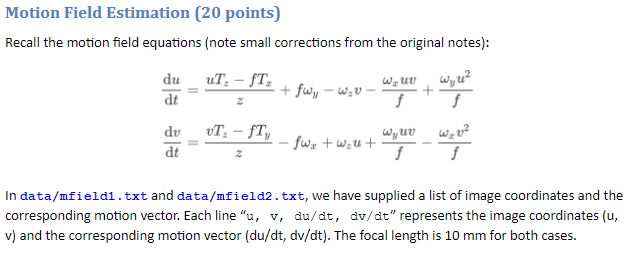

In [3]:
# load data
response = requests.get('https://github.com/qchenclaire/computer-vision-fall-2020/raw/master/HW3/data/mfield1.txt')
response.raise_for_status()
mfield1 = np.loadtxt(io.BytesIO(response.content))

response = requests.get('https://github.com/qchenclaire/computer-vision-fall-2020/raw/master/HW3/data/mfield2.txt')
response.raise_for_status()
mfield2 = np.loadtxt(io.BytesIO(response.content))

print(mfield1.shape, mfield2.shape)

(20, 4) (20, 4)


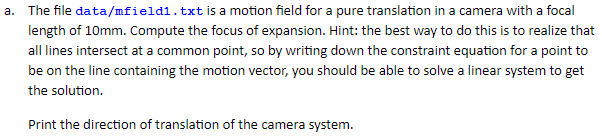

Functions for motion estimation

In [50]:
rotate2d = lambda t: np.array([[np.cos(t), -np.sin(t)],[np.sin(t), np.cos(t)]])

def unpack_data(data_mat):
    ''' Make it easy to unpack'''
    
    return data_mat[:,0], data_mat[:,1], data_mat[:,2], data_mat[:,3]

# unpack_data

def correct_rotation(u, v, du_dt, dv_dt, f, w):
    ''' Function to remove the rotational aspect out of image velocities'''
    wx, wy, wz = w
    du_dt_trans = du_dt - f*wy + wz*v + wx/f*u*v - wy/f * u**2
    dv_dt_trans = dv_dt + f*wx - wz*u - wy/f*u*v + wx/f * v**2
    
    
    return u, v, du_dt_trans, dv_dt_trans    
    
# def

def trans_estimation(u, v, du_dt, dv_dt, f, w = np.array([0,0,0])):
    ''' Calculate the translation estimation (assuming only translation)
        * Can get translation up to scale factor since no z found *
        assumes omega = 0 ( no rotational velocity )
    '''
    # remove rotation
    u, v, du_dt, dv_dt = correct_rotation(u, v, du_dt, dv_dt, f, w)
    
    # gather the least squares matrices 
    A = np.zeros((2*len(u), 3))
    b = np.zeros(2*len(u))
    
    A[::2, 0] = -f
    A[1::2, 1] = -f
    
    A[::2,2] = u
    A[1::2, 2] = v
    
    b[::2] = du_dt
    b[1::2] = dv_dt
    
    T, *_ = np.linalg.lstsq(A, b, rcond=None)
    
    T /= np.linalg.norm(T) # normalize
    
    return T
    
    
# trans_estimation

def calc_foe(u, v, du_dt, dv_dt, f, w=np.array([0,0,0])):
    ''' Calculate the focus of expansion from the motion field
        
        Theory:
            p = ( u, v )

            We have that ( p - p0 ) // dp_dt
            R = rotate2d(90 degrees)

            (p - p0) normal to R @ dp_dt

            p . (R @ dp_dt) = p0 . (R @ dp_dt)
    
    '''
    # remove rotation
    u, v, du_dt, dv_dt = correct_rotation(u, v, du_dt, dv_dt, f, w)
    
    # prepare least squares
    R_90 = rotate2d(np.pi/2) 
    p = np.vstack((u,v)) # image points
    dp_dt = np.vstack((du_dt, dv_dt)) # image point velocities
    
    # perform least squares
    A = dp_dt.T @ R_90.T
    b = np.diag(A @ p) # A @ p is tensor of all the dot products. Only want the diagonal where dotted against itself
    
    p0, *_ = np.linalg.lstsq(A, b, rcond=None)
    
    return p0
    
# calc_foe    

def time2collision(u, v, du_dt, dv_dt, f, w=np.array([0,0,0])):
    ''' Calculate the time to collision'''
    # remove rotation
    u, v, du_dt, dv_dt = correct_rotation(u, v, du_dt, dv_dt, f, w)
    
    p0 = calc_foe(u, v, du_dt, dv_dt, f, w=np.array([0,0,0])) # FoE
    p = np.vstack((u, v)).T
    dp_dt = np.vstack((du_dt, dv_dt)).T
    
    # calcualte time to collision
    dist = np.linalg.norm(p0 - p, axis=1) # distance from FoE
    vel = np.linalg.norm(dp_dt, axis=1) # velocity
    
    ttc = dist/vel
    
    return ttc

# time2collision


In [44]:
# a
answers['MF'] = {}
answers['MF']['a'] = {}

f = 10
# TODO: foe should be an array of shape (2,)
foe = calc_foe(*unpack_data(mfield1), f)
print("focus of expansion = ", foe)
answers['MF']['a']['foe'] = foe

# TODO: tranlsation should be a unit vector, an array of shape(3,)
translation = trans_estimation(*unpack_data(mfield1), f)
print("translation = ", translation)
answers['MF']['a']['translation'] = translation

focus of expansion =  [16. 18.]
translation =  [0.58719065 0.69942441 0.40744649]


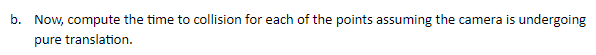

In [45]:
# b
answers['MF']['b'] = {}

# TODO: an array of (20,)
time_collision = time2collision(*unpack_data(mfield1), f)
print("time to collision = ", time_collision)
answers['MF']['b']['time_collision'] = time_collision

time to collision =  [5.39701197 4.61079523 0.37932793 2.71853071 1.75569237 5.70174597
 2.84518581 4.30098548 5.28852458 0.78942405 2.96205317 0.65455632
 2.11038528 5.86048596 4.43684528 2.72184114 2.57573883 1.20675204
 4.35169011 4.43002191]


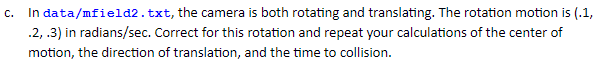

focus of expansion =  [50. 15.]
translation =  [0.96382984 0.24948225 0.09375851]
time to collision =  [22.75894777 20.68179232  2.86130306  6.7954655   5.61002348 15.88213466
 21.61518049 25.09655433 16.67313403 24.38280201 21.88221069 13.27129155
 27.26915166 28.33894418 24.34329096 24.03791468  3.4024239   8.88409508
 15.24377196 10.33740839]


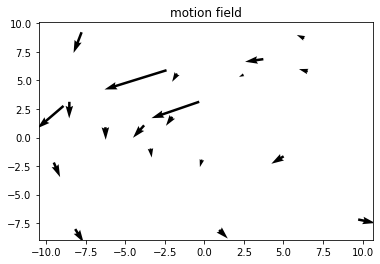

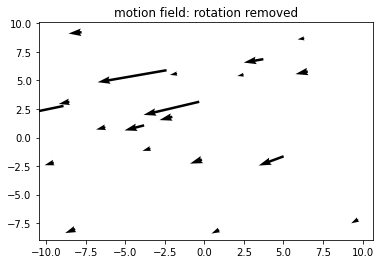

In [53]:
# c
answers['MF']['c'] = {}
f = 10
w = np.array([.1, .2, .3]) # angular velocity ( rads/s )

# correct rotation
plt.figure()
mfield2_unpack = unpack_data(mfield2)
plt.quiver(*mfield2_unpack)
plt.title('motion field')

plt.figure()
mfield2_unpack_trans = correct_rotation(*mfield2_unpack, f, w)
plt.quiver(*mfield2_unpack_trans)
plt.title('motion field: rotation removed')

# TODO: foe should be an array of shape (2,)
foe = calc_foe(*unpack_data(mfield2), f, w=w)
print("focus of expansion = ", foe)

# TODO: tranlsation should be a unit vector, an array of shape(3,)
translation = trans_estimation(*unpack_data(mfield2), f, w=w)
print("translation = ", translation)

# TODO: an array of (20,)
time_collision = time2collision(*unpack_data(mfield2), f, w=w)
print("time to collision = ", time_collision)

answers['MF']['c']['foe'] = foe
answers['MF']['c']['translation'] = translation
answers['MF']['c']['time_collision'] = time_collision

## Visual Tracking
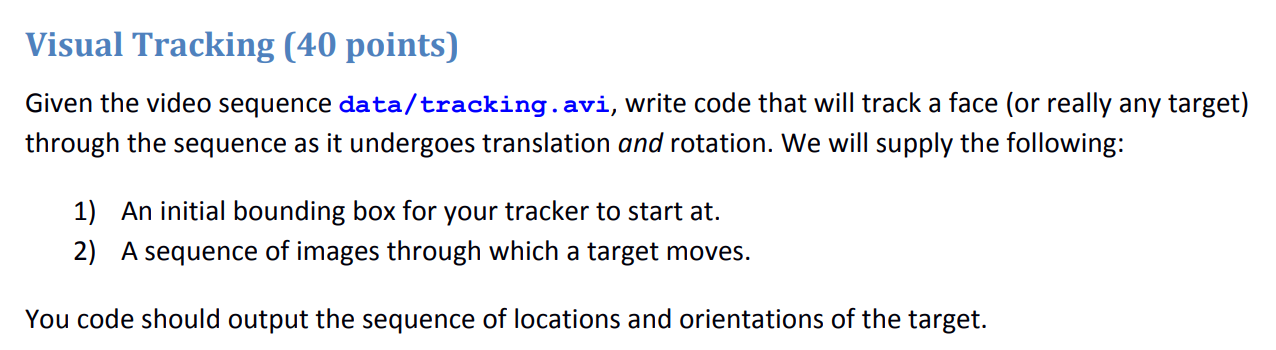

In [ ]:
# download video
if not os.path.exists('tracking.avi'):
    ! wget https://github.com/qchenclaire/computer-vision-fall-2020/raw/master/HW3/data/tracking.avi

# play the video
path ="tracking.avi" 
clip = VideoFileClip(path)
clip.ipython_display()

In [ ]:
# load video into a generator of images
def v2i(filename, scale=1):
    cap = cv2.VideoCapture(filename)
    while(True):
        ret, frame = cap.read()
        if ret: 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (frame.shape[1] // scale, frame.shape[0] // scale))
            yield frame
        else: break

# show first frame
# downsample scale. If the motion is too large you may want to downsample the image. But for autograding, keep scale as 1
scale = 1
video = v2i('tracking.avi', scale)
frame0 = next(video)
plt.imshow(frame0, cmap = 'gray')

In [ ]:
def crop_rotated(image, center, window_size, angle):
    """ Crops a region from image centered about center, of size window_size, and 
      at angle angle.
      Args:
        image: Image to be cropped, of shape [height, width, channels]
        center: Center of crop, (col index, row index))
        window_size: Size of window to crop, of shape tuple (int, int)
        angle: Angle of window to crop, int. The angle is in degree and a positive angle rotates the box clockwisely.
      Returns:
        image_crop: Cropped rotated image about center and at angle
                    shape should be [window_size[0], window_size[1], channels]
    """

    # Formats the inputs to the required format
    center, window_size = tuple(map(int, center)), tuple(map(int, window_size))

    # Get the shape of the image 
    height, width = image.shape[0], image.shape[1]

    # Calculate the rotation matrix about the center provided
    M = cv2.getRotationMatrix2D(center, angle, 1)

    # Rotate the original image
    image_rot = cv2.warpAffine(image, M, (width, height))

    # Crop from the rotated image
    image_crop = cv2.getRectSubPix(image_rot, window_size, center)

    return image_crop


# show target of the first frame
d0 = np.array([350., 210.]) / scale
s = (101 / scale, 101 / scale)
theta0 = 0
tgt = crop_rotated(frame0, d0, s, theta0)
plt.imshow(tgt, cmap='gray')

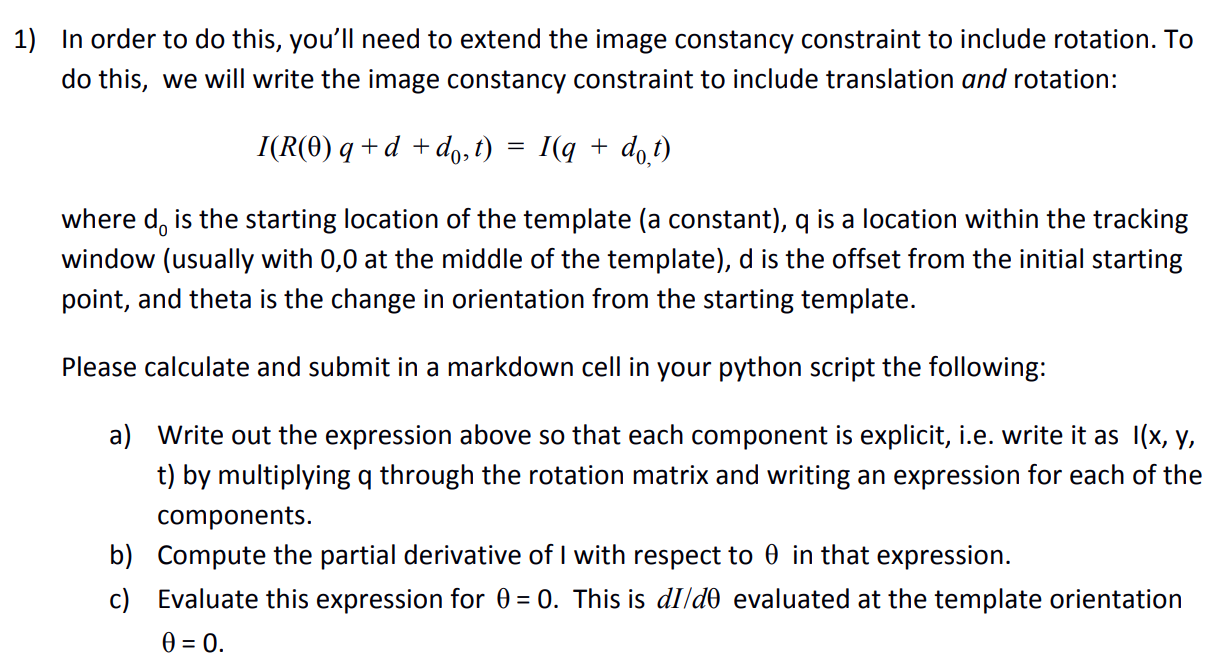

write your formulas here: use latex syntax to type formula.
e.g. $$f(\theta)=\frac{2}{3}$$

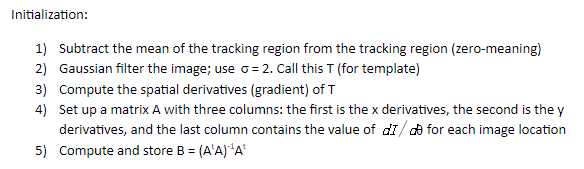

In [ ]:
# initialization 1: Subtract the mean of the tracking region from the tracking region (zero-meaning)
# TODO: array of (101, 101)
normalized_tgt = 

# do not modify answers format
answers['Tracking'] = {}
answers['Tracking']['init1'] = normalized_tgt.sum()

In [ ]:
# initialization 2: Gaussian filter the image; use = 2. Call this T (for template)
# TODO: array of (101, 101)
T = 
answers['Tracking']['init2'] = T.sum()

In [ ]:
# initialization 3: Compute the spatial derivatives (gradient) of T

# TODO: gy, gx are both array of (101, 101), use np.gradient()
gy, gx= 


answers['Tracking']['init3'] = {}
answers['Tracking']['init3']['gx'] = gx.sum()
answers['Tracking']['init3']['gy'] = gy.sum()

In [ ]:
# initialization 4: Set up a matrix A with three columns: 
# TODO: 
A = 
answers['Tracking']['init4'] = A.sum()

In [ ]:
# initialization 5: Compute and store B
# TODO:
B = 
answers['Tracking']['init5'] = A.sum()

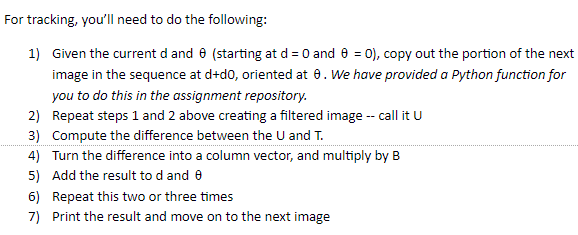

In [ ]:
# utility function to draw rotated box on image
def center_to_corner_box2d(center, dim, angle):
    """ change box representation from (center, dimension, angle) to coordinates of four corners
      Args:
        center: (col index, row index)
        dim: (width, height)
        angle: Angle of window to crop, int. The angle is in radian and a positive angle rotates the box clockwisely.
      Returns:
        corners: 4 x 2 array and each row is a corner coordinate
    """ 
    corners = np.array([[-0.5, -0.5], [-0.5, 0.5], [0.5, 0.5], [0.5, -0.5]])
    corners[:, 0] *= dim[0] 
    corners[:, 1] *= dim[1]
    c, s = np.cos(-angle), np.sin(-angle)
    R = np.array(((c, -s), (s, c)))
    corners = (R @ corners.T).T
    corners[:, 0] += center[0]
    corners[:, 1] += center[1]
    return corners
    
    

In [ ]:
# tracking
video = v2i('tracking.avi', scale)
ori_video = v2i('tracking.avi')
d = np.zeros_like(d0)
theta = 0
d_seq = []
theta_seq = []

# store output video for demo
out = []
while True:
    try:
        frame = next(video)
        # TODO: 1) - 7)

        # draw box on video for demo
        ori_frame = next(ori_video)
        box_corner = center_to_corner_box2d((d0+d) * scale, (s[0] * scale, s[1] * scale), theta0+theta)
        cv2.drawContours(ori_frame,[box_corner.astype(int)],0,(0,0,255),2)
        out.append(ori_frame)


        d_seq.append(d)
        theta_seq.append(theta)

    except:
        break
# array of (650, 2)
d_seq = np.vstack(d_seq)
# array of (650,)
theta_seq = np.array(theta_seq)
answers['Tracking']['d_seq'] = d_seq[10::50]
answers['Tracking']['theta_seq'] = theta_seq[10::50]

In [ ]:
# show annotated video
clip = ImageSequenceClip(out, fps=20)
clip.ipython_display()

In [ ]:
# show expected results of the first 50 frames(demo is in BGR but doesn't matter). You need to do the full video.
if not os.path.exists('demo.avi'):
    ! wget https://github.com/qchenclaire/computer-vision-fall-2020/raw/master/HW3/demo.avi

# play the video
path ="demo.avi" 
clip = VideoFileClip(path)
clip.ipython_display()

In [ ]:
# finally submit your answers.pickle and HW3.ipynb. Please do not miss either file or add extra files. Wait for some time for answers.pkl to appear in your folder. Yay! This is the end of all the homeworks!
pickle.dump(answers, open('answers.pkl', 'wb'))